In [1]:
import numpy as np
import os
import scipy.io as sio
from skimage.io import imread, imsave
from skimage.transform import rescale, resize
from time import time
import matplotlib.pyplot as plt
import ast
import cv2
import tensorflow as tf

from api import PRN

from utils.estimate_pose import estimate_pose
from utils.rotate_vertices import frontalize
from utils.render_app import get_visibility, get_uv_mask, get_depth_image
from utils.write import write_obj_with_colors, write_obj_with_texture
from utils.cv_plot import plot_kpt, plot_vertices, plot_pose_box

tf.compat.v1.enable_resource_variables()
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # GPU number, -1 for CPU

## Load Image

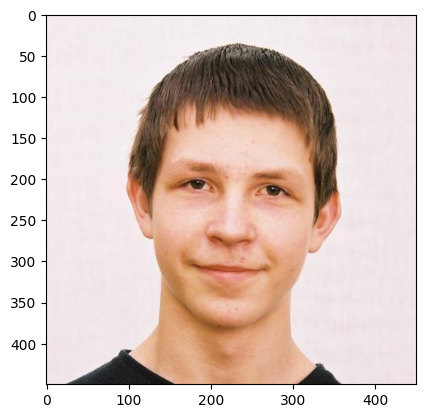

In [28]:
image_path = 'TestImages/0.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Features

In [4]:
prn = PRN(is_mtcnn=True)

### face detection

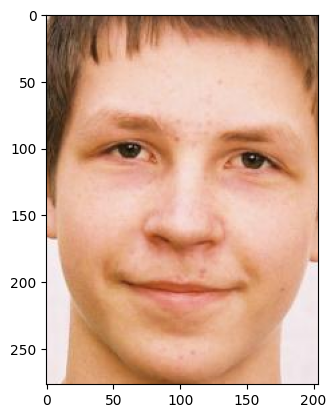

In [13]:
# use face detect to find face and crop it
box = prn.face_detect(image)

image = image.copy()
left = box[0]['box'][0]
top = box[0]['box'][1]
right = box[0]['box'][0] + box[0]['box'][2]
bottom = box[0]['box'][1] + box[0]['box'][3]

image_crop = image[top:bottom, left:right]
image_crop =image_crop/255.
plt.imshow(image_crop)

### 3d Image

In [20]:
[h, w, c] = image_crop.shape

pos = prn.process(image)
vertices = prn.get_vertices(pos)
save_vertices = vertices.copy()
save_vertices[:,1] = h - 1 - save_vertices[:,1]

colors = prn.get_colors(image, vertices)

#### with texture

##### without mask

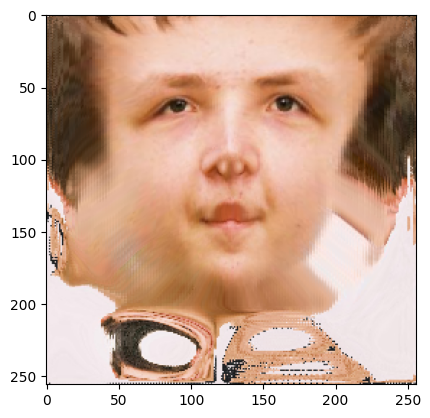

In [24]:
pos_interpolated = pos.copy()
texture = cv2.remap(image, pos_interpolated[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
plt.imshow(texture)

##### with mask

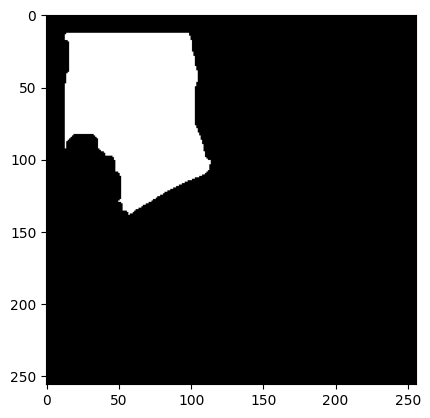

In [23]:
# whether to set invisible pixels(due to self-occlusion) in texture as 0
texture_size = 256

vertices_vis = get_visibility(vertices, prn.triangles, h, w)
uv_mask = get_uv_mask(vertices_vis, prn.triangles, prn.uv_coords, prn.resolution_op)
uv_mask = resize(uv_mask, (texture_size, texture_size), preserve_range = True)
texture = texture*uv_mask[:,:,np.newaxis]
plt.imshow(texture)

### Depth

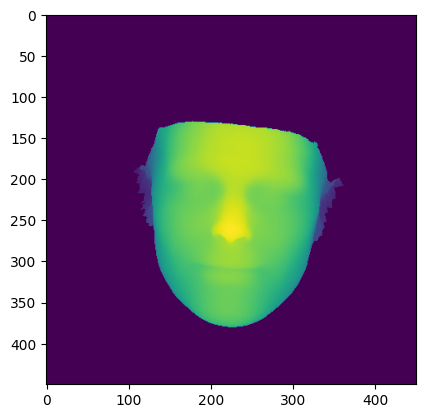

In [37]:
image_path = 'TestImages/0.jpg'

pos = prn.process(image_path)
vertices = prn.get_vertices(pos)

depth_image = get_depth_image(vertices, prn.triangles, 450, 450, True)
depth = get_depth_image(vertices, prn.triangles, 450, 450)
plt.imshow(depth_image)

### Landmark

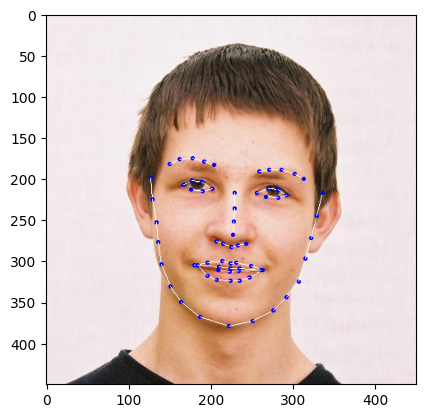

In [34]:
kpt = prn.get_landmarks(pos)
plt.imshow(plot_kpt(image, kpt))